# 导入库

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from environment import stock

plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# 网络

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

n_outputs = 5 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, 
                       activation='relu', 
                       padding='same', 
                       input_shape=[575, 800, 3]), 
    # 👆 64个滤波器，核高宽7（卷积层），核越大保留信息越多 
    keras.layers.MaxPool2D(2), # 池化层，大小2，在每个维度除以2(等于步幅)
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    # 重复滤波、池化，每池化一次，滤波器数理加倍，因为池化后空间维度除以2，不用担心参数爆炸增长
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(), # 把图像转为一维数组，接上全连接网络
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5), # 每次drop一半神经元防止过拟合
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(n_outputs), # 输出五个动作价值
    ])

# 贪婪策略

In [ ]:
def epsilon_greedy_policy(model, state, epsilon=0): # epsilon设定贪婪度，越高则越选择Q值高的动作
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs) # 在1-epsilon概率下随机选择动作
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0] # 出来之后应该有两个维度，去掉最外层方便后续
        return Q_values.argmax() # DQN给出的Q值最高的动作索引

# 创建经验表

In [ ]:
from collections import deque

# 重播缓存
replay_buffer = deque(maxlen=2000)  # 长度2000的双端列表，性质类似list但是处理复杂度更低

# 经验采样

In [ ]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    # 0~2000的均匀分布，抽取大小为batch_size的随机数组
    batch = [replay_buffer[index] for index in indices]  # 按随机序号抽取缓存中的经验
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]  # [states, actions, rewards, next_states, dones] 每个元素是一个ndarray数组

# 运行单步

In [ ]:
def play_one_step(model, env, state, epsilon):
    action = epsilon_greedy_policy(model, state, epsilon)
    next_state, reward, done = env.step(action)
    replay_buffer.append(
        (state, action, reward, next_state, done)
    )  # 经验缓存中增加经验
    return next_state, reward, done

# 初始化

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)  # 优化器
loss_fn = tf.keras.losses.mean_squared_error  # 损失函数mse

env = stock()

# 训练函数

In [ ]:
target = tf.keras.models.clone_model(model)  # 复制一个新的模型（初始状态一致）
target.set_weights(model.get_weights())  # 应用权重


def training_step(batch_size):
    experiences = sample_experiences(batch_size) # 提取经验
    states, actions, rewards, next_states, dones  = experiences

    next_Q_values = model.predict(
        next_states, verbose=0
    )  # ≠ target.predict()
    best_next_actions = next_Q_values.argmax(axis=1)  # 直接取动作而非Q值
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask).sum(axis=1) 
    # 计算Q值使用目标模型

    runs = 1.0 - dones
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

# 运行模型

In [ ]:
for episode in range(500):  # 500回合
    obs = env.reset() # 重写初始化状态
    for step in range(50):  # 执行最多50步
        epsilon = max(1 - episode / 500, 0.01)  # 功率调节，最小是0.01，线性降低，epison/回合数
        obs, reward, done = play_one_step(model, env, obs, epsilon=)
        if done:
            break
    # 显示信息并且应用最佳权重 #
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, ε: {epsilon:.3f}", end="")
    rewards.append(step)  # 记录本回合最终分数
    if step >= best_score:  # 最终步骤数实际上等于奖励分数
        best_weights = model.get_weights()  # 获得本回合的权重
        best_score = step  # 保留该回合最高分,前面已经提到回合数等于分值

    if episode > 50:  # 50个回合之后再训练，目的是先增加经验，但是具体加了多少不确定，因为每回合步骤是随机的
        training_step(batch_size)
        if episode % 50 == 0:  ##### 50回合修改一次目标模型的权重 #####
            target.set_weights(model.get_weights())

model.set_weights(best_weights)  # 把最佳权重赋值到模型

# 测试

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from environment import stock

In [2]:
env = stock()

get_data(code, start, long)在线下载数据
reset()返回一个初始k线图
step(action)采取动作action


In [3]:
obs = env.reset()

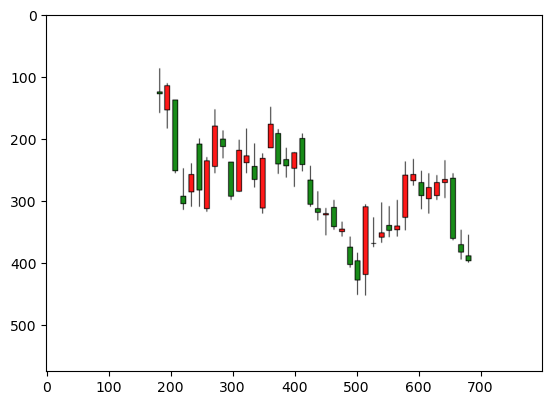

In [4]:
plt.imshow(obs)

In [5]:
next_state, reward, done = env.step(1)

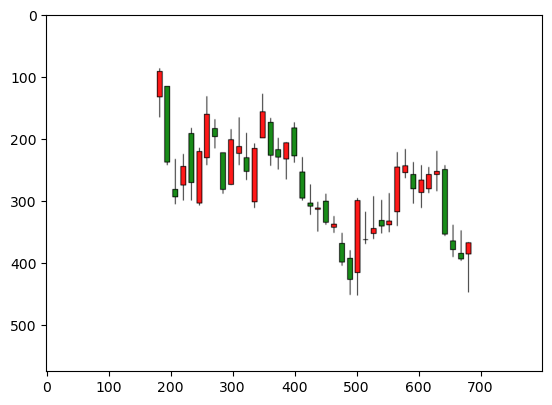

In [6]:
plt.imshow(next_state)

In [7]:
reward

0.001862197392923625